SW115 (Daudkandi)_Daily_Avg
SW14.5 (Nayarhat)_Daily_Avg
SW177 (Lakhpur)_Daily_Avg
SW190 (Mostafapur)_Daily_Avg
SW193 (Kabirajpur)_Daily_Avg
SW229 (Toke)_Daily_Avg
SW230.1 (Ramnagar)_Daily_Avg
SW248 (Dohazari)_Daily_Avg
SW272.1 (Austogram)_Daily_Avg
SW273 (Bhairab Bazar)_Daily_Avg
SW274 (Narsingdi)_Daily_Avg
SW295 (Ajabpur)_Daily_Avg
SW297 (Gokarnaghat)_Daily_Avg
SW298 (Nabinagar)_Daily_Avg
SW298.5 (Salimganj)_Daily_Avg
SW299 (Tongi)_Daily_Avg
SW5 (Madaripur)_Daily_Avg
SW69 (Savar)_Daily_Avg
SW7 (Pubail)_Daily_Avg
SW70 (Kalatia Outfall)_Daily_Avg


C:\Users\MDS\anaconda3\envs\py377\lib\site-packages\ipykernel_launcher.py:235: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


SW72 (Khaliajuri)_Daily_Avg
SW73 (Itna)_Daily_Avg
SW74 (Dilalpur)_Daily_Avg
SW9 (Kauraid)_Daily_Avg


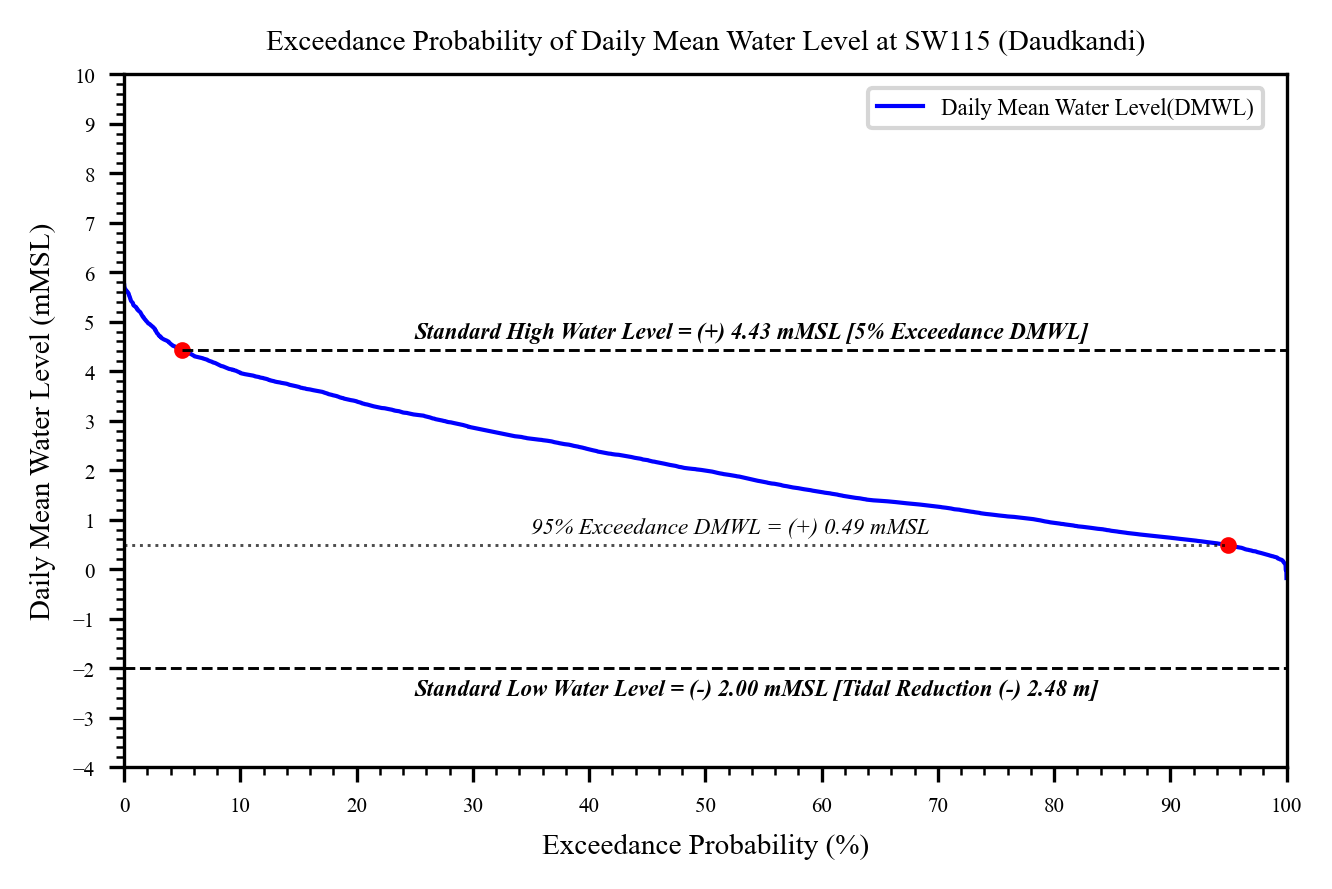

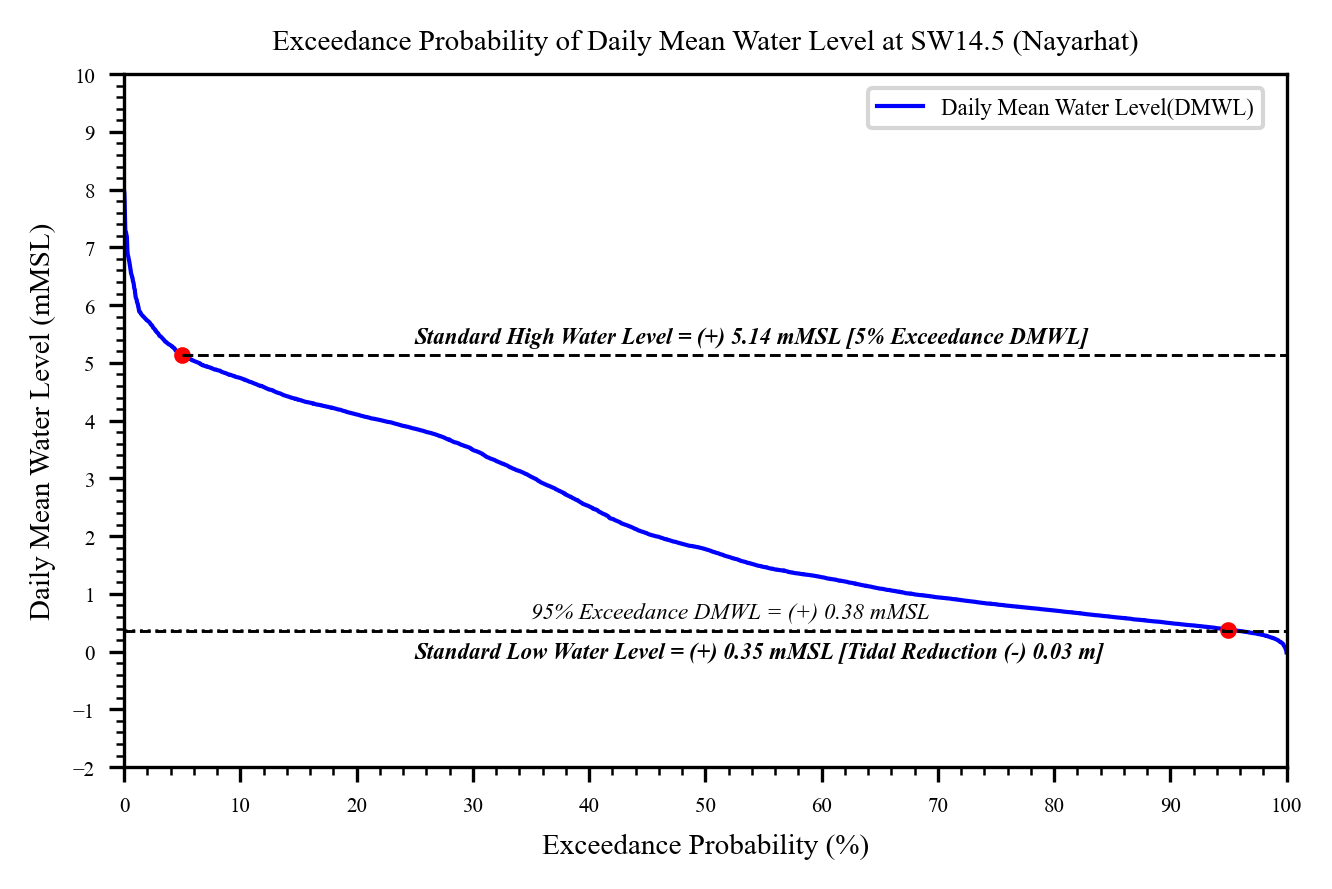

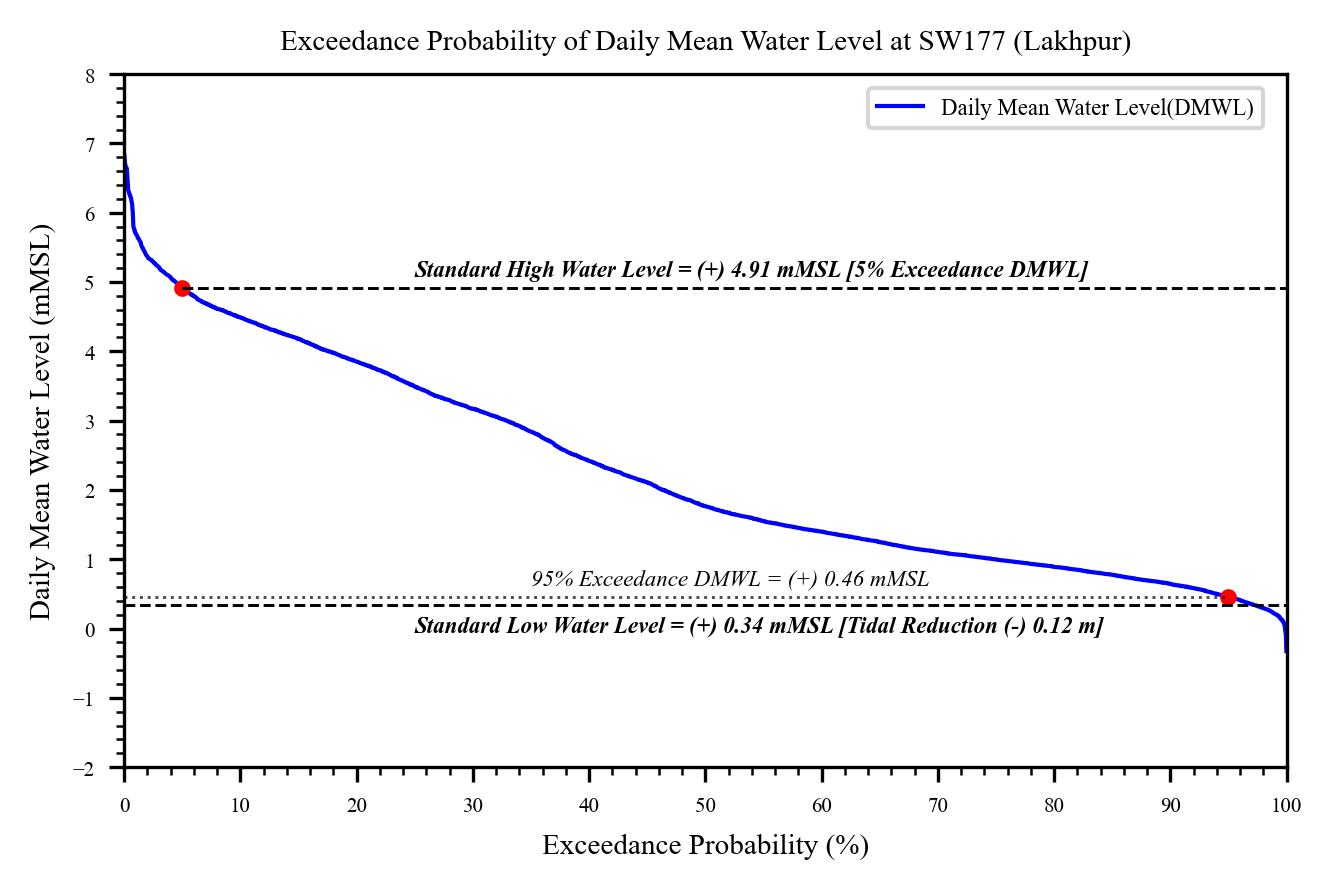

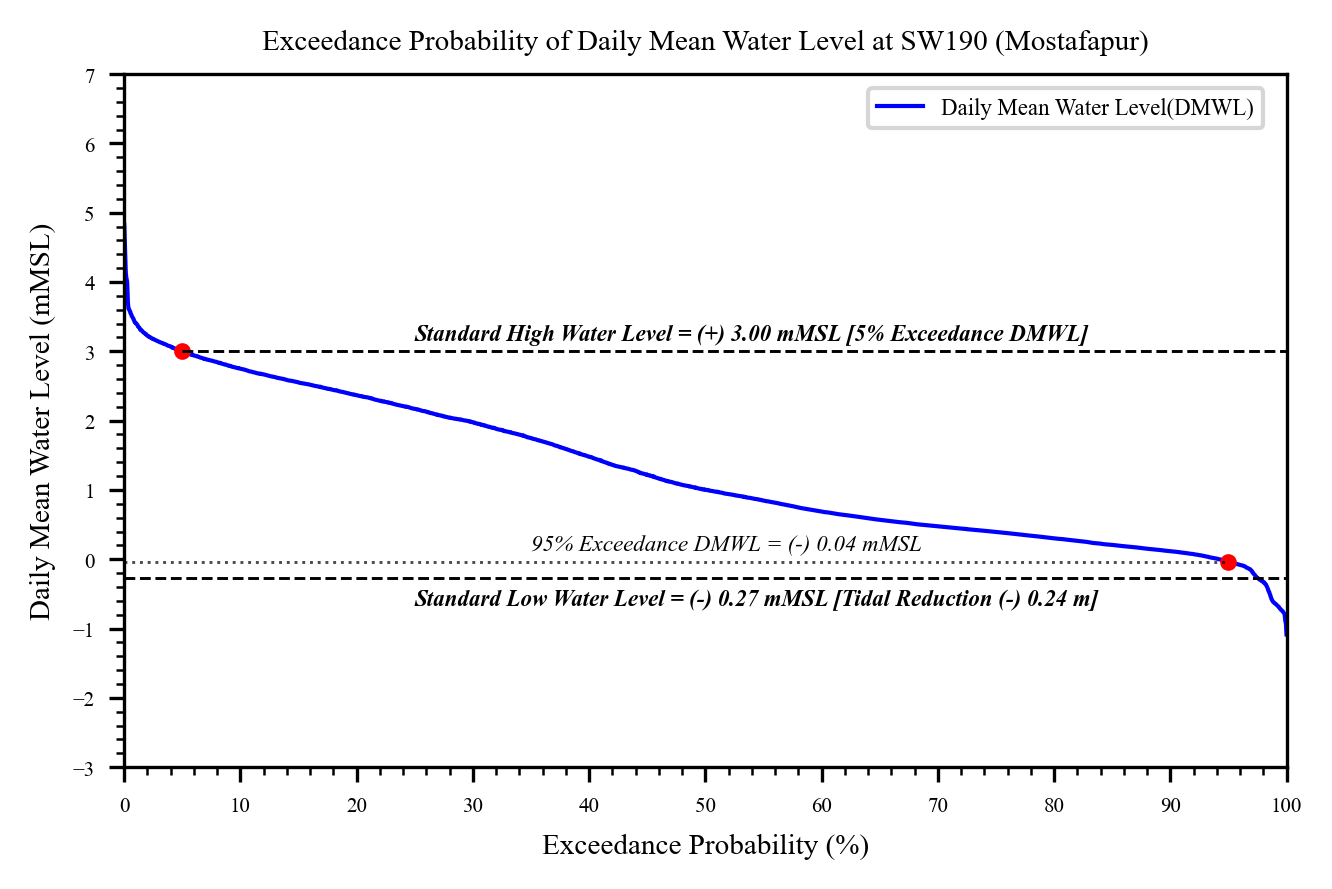

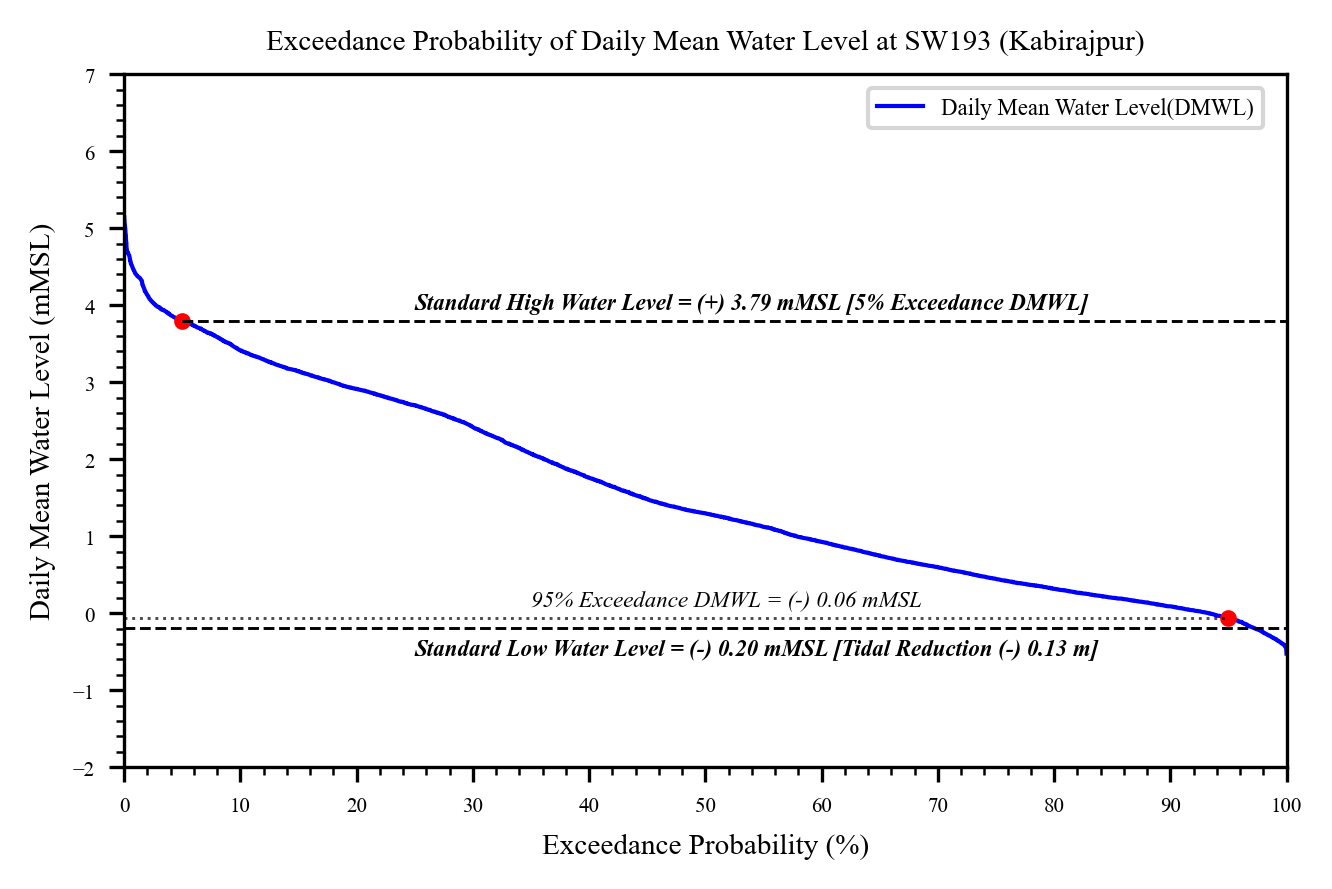

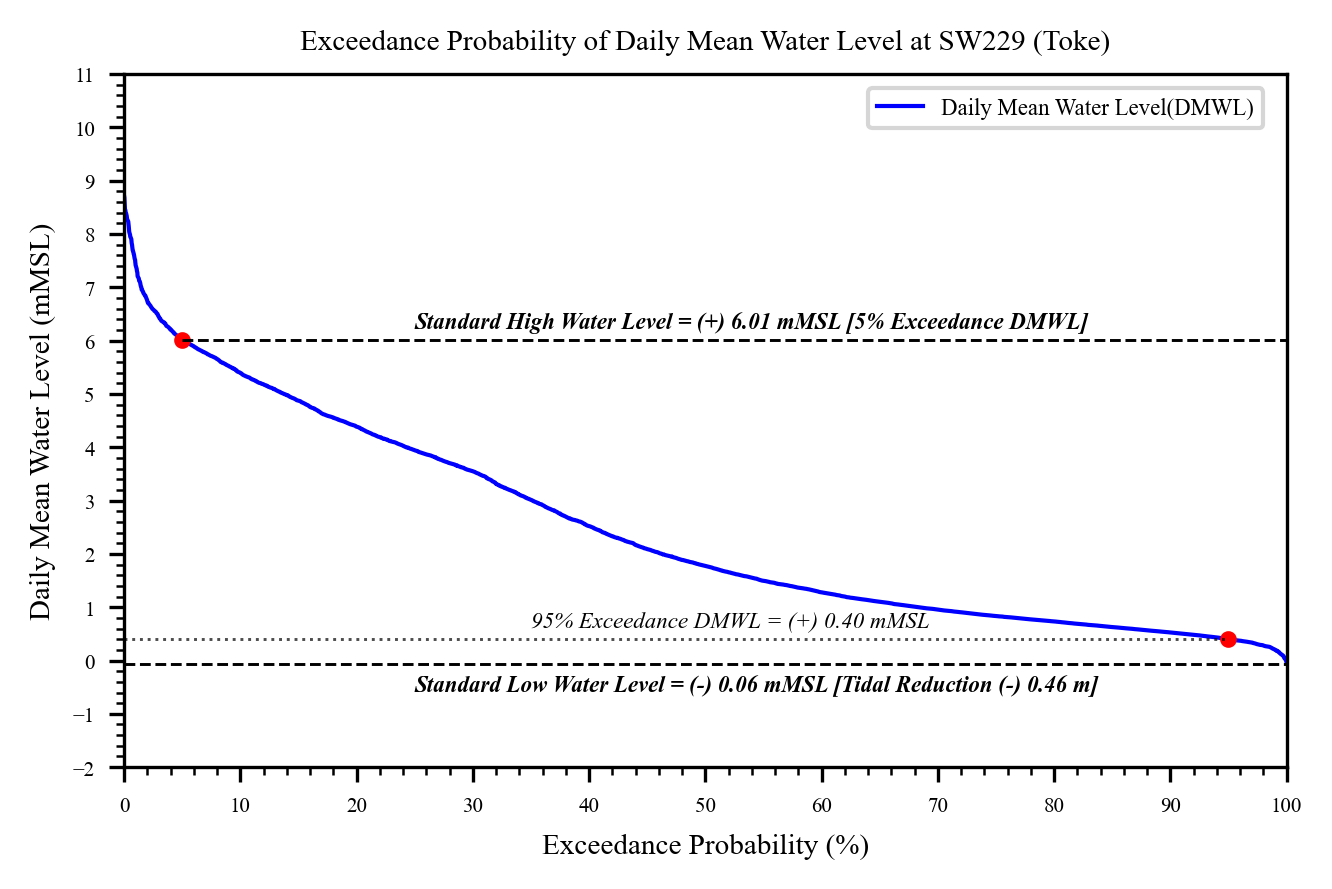

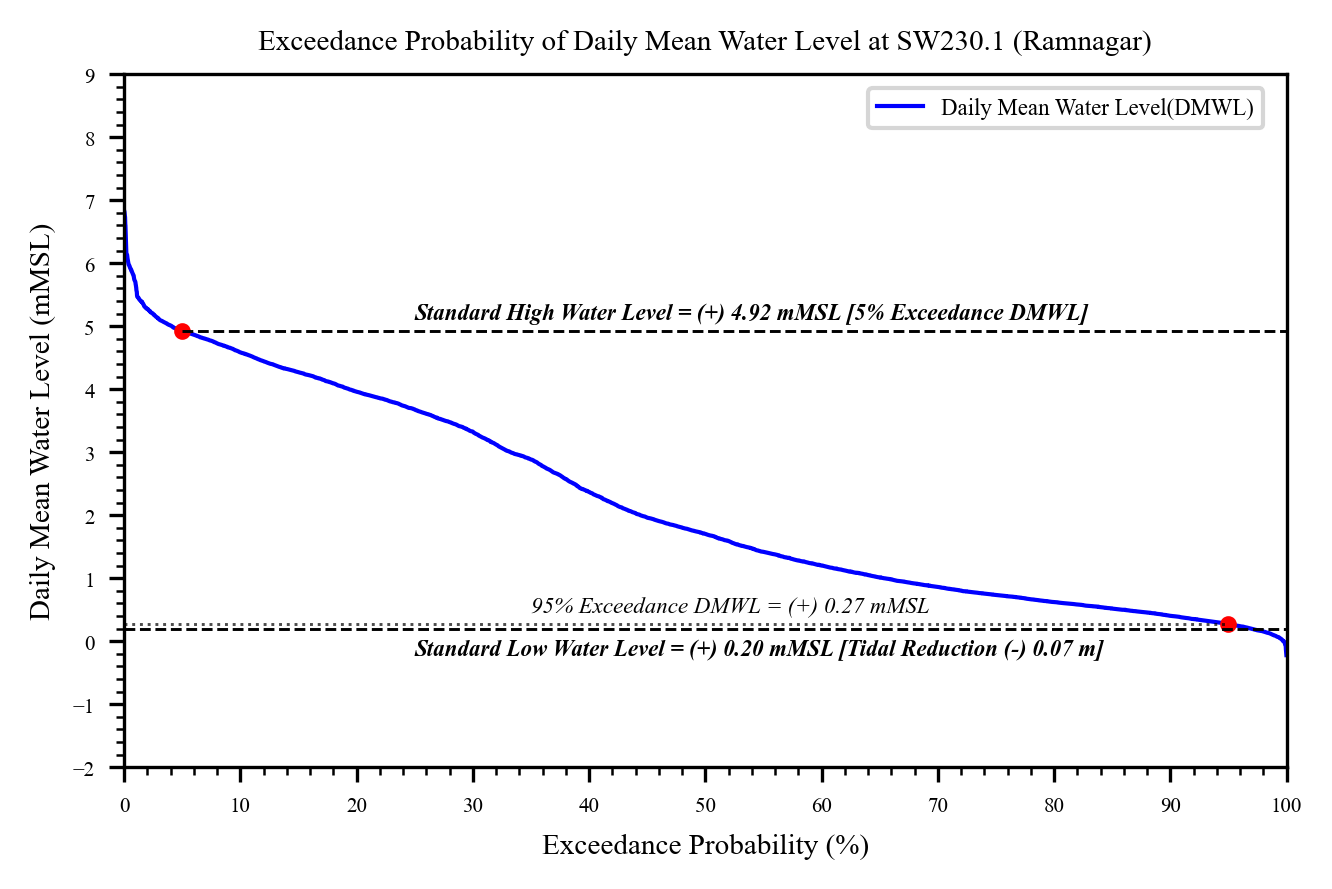

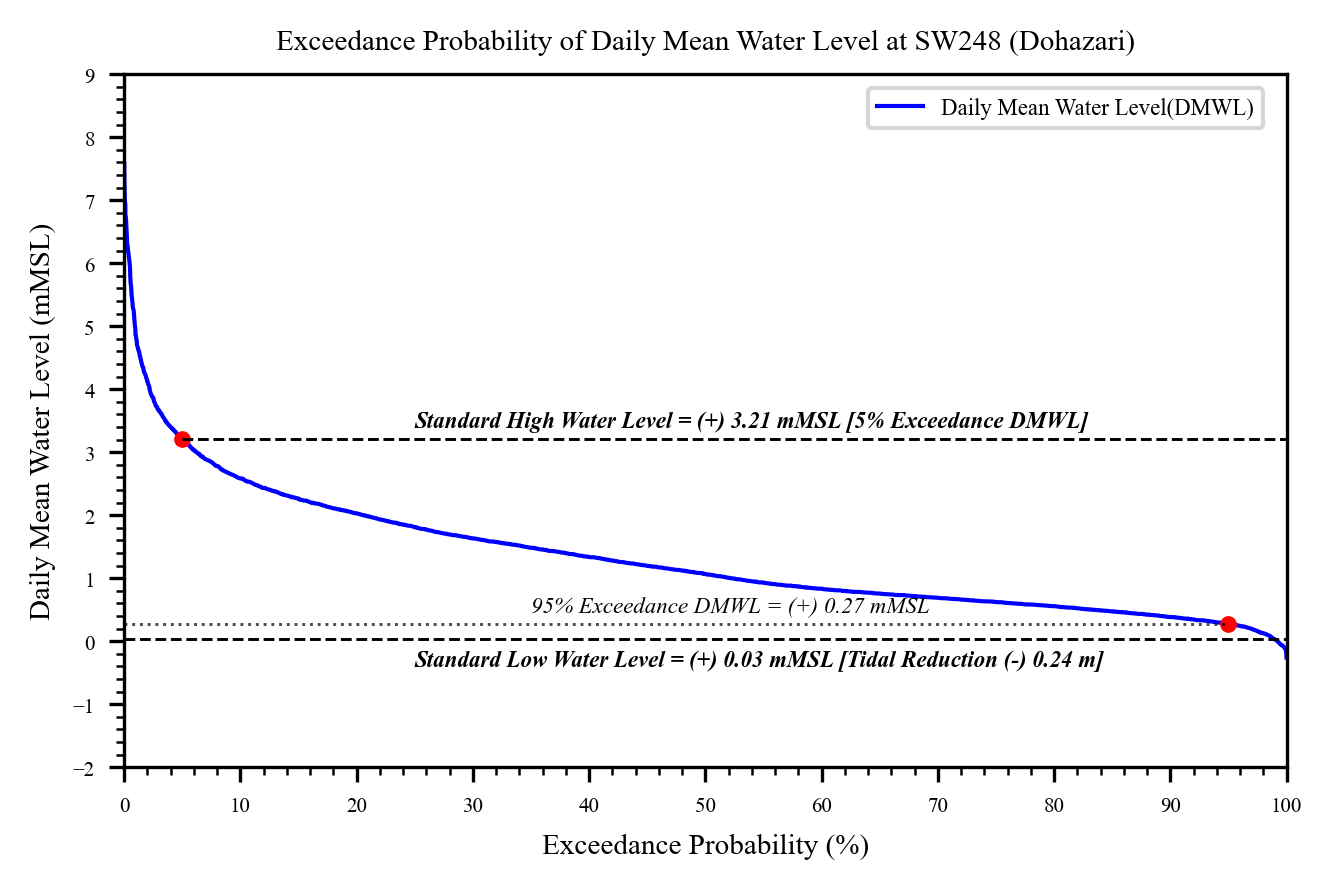

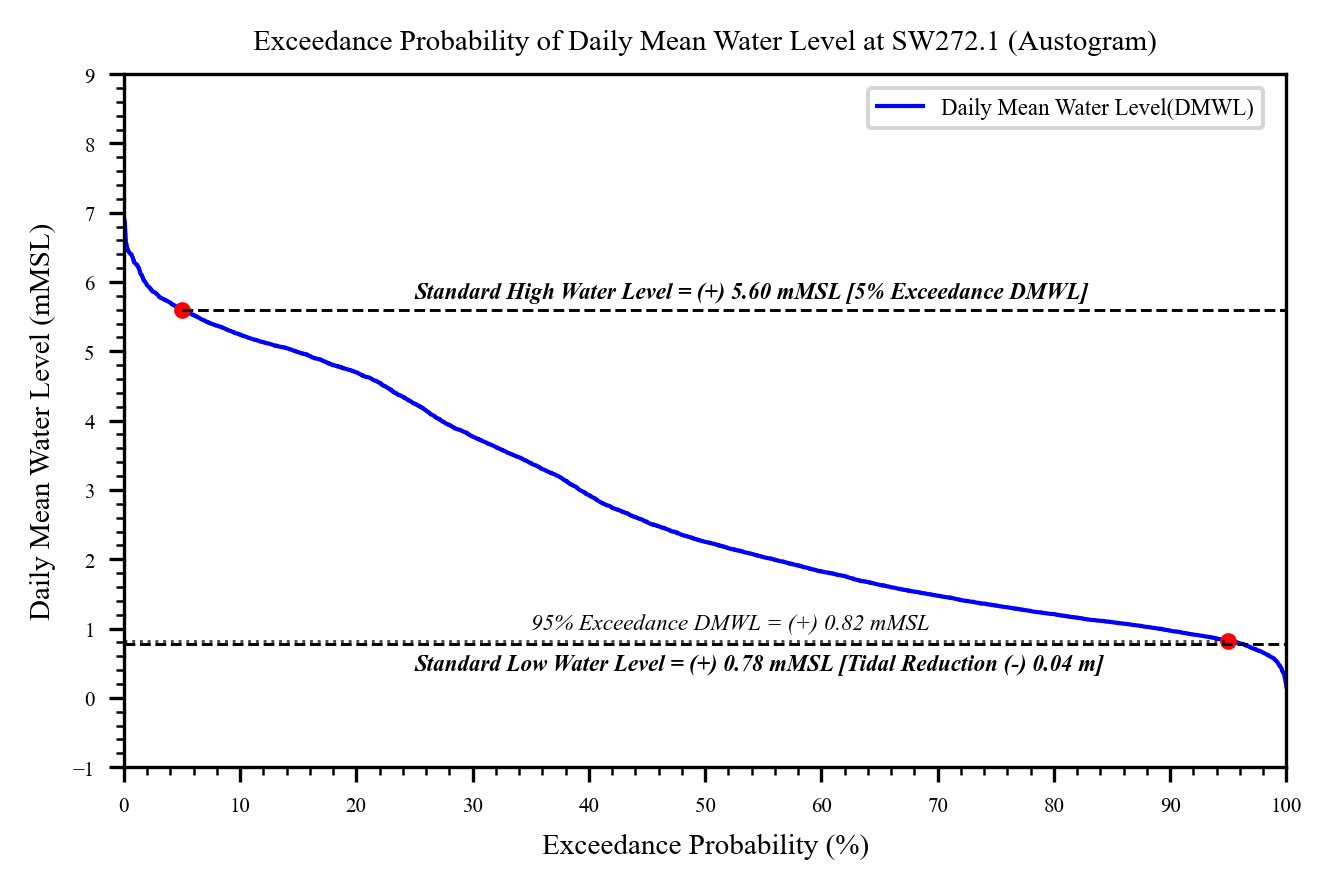

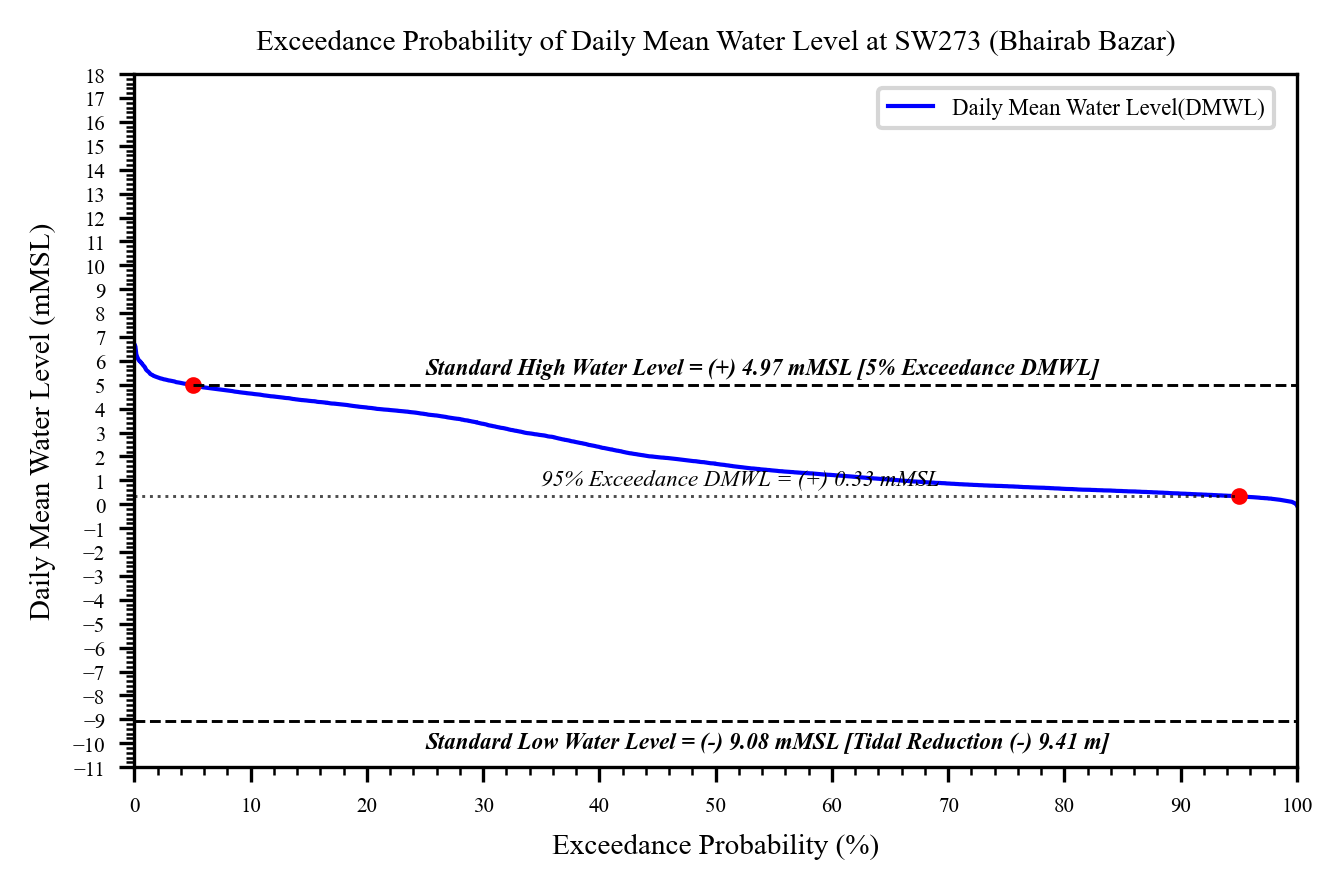

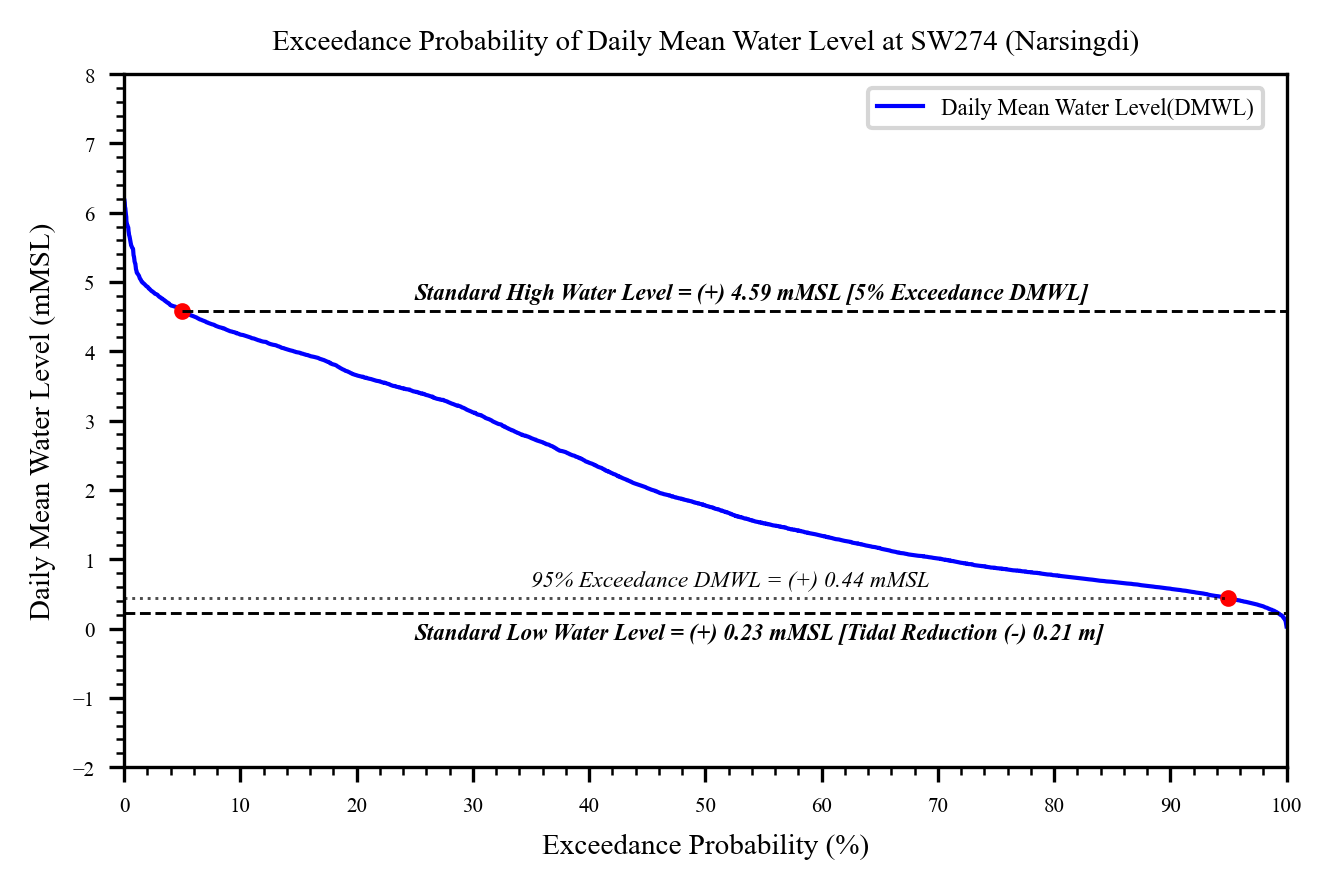

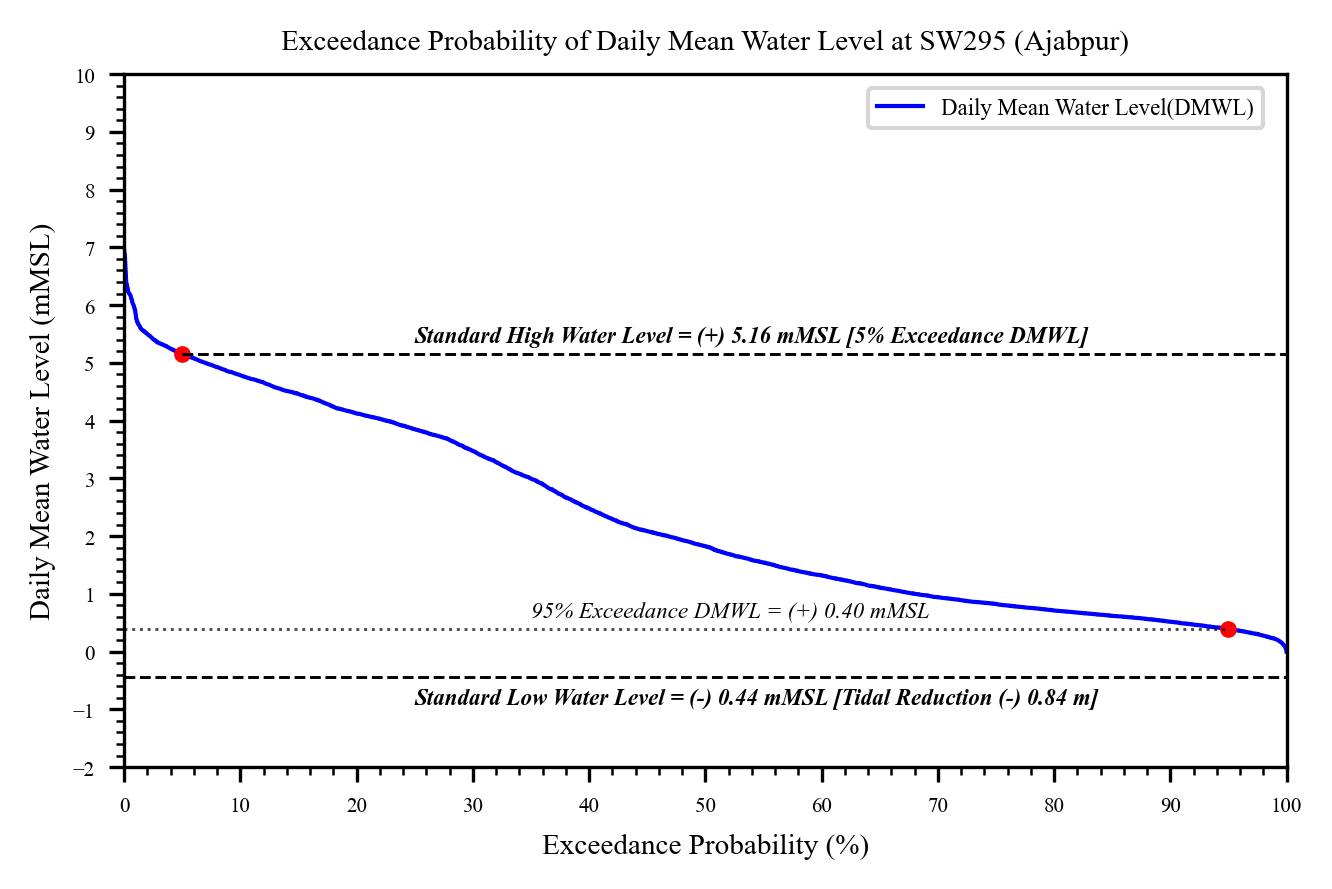

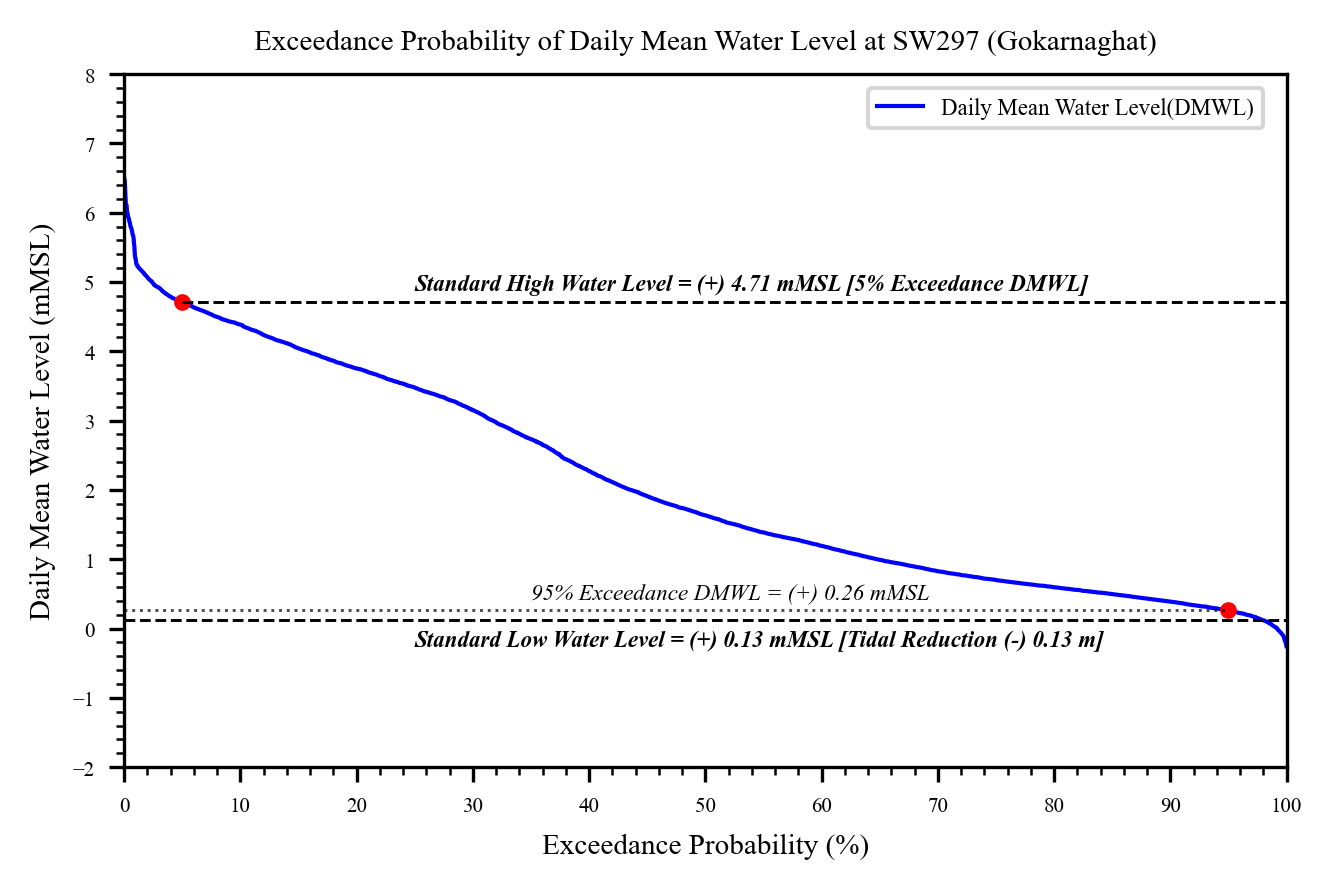

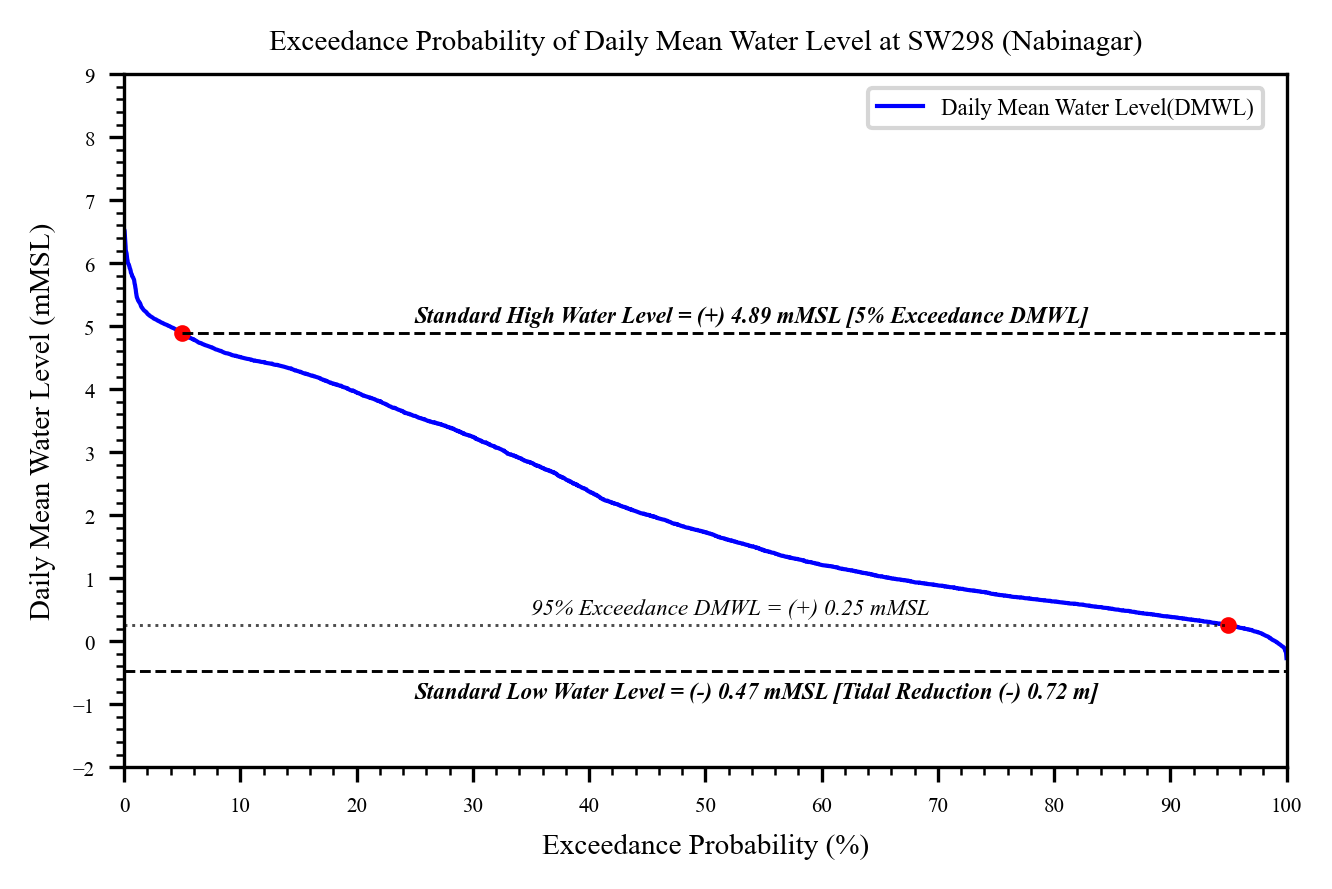

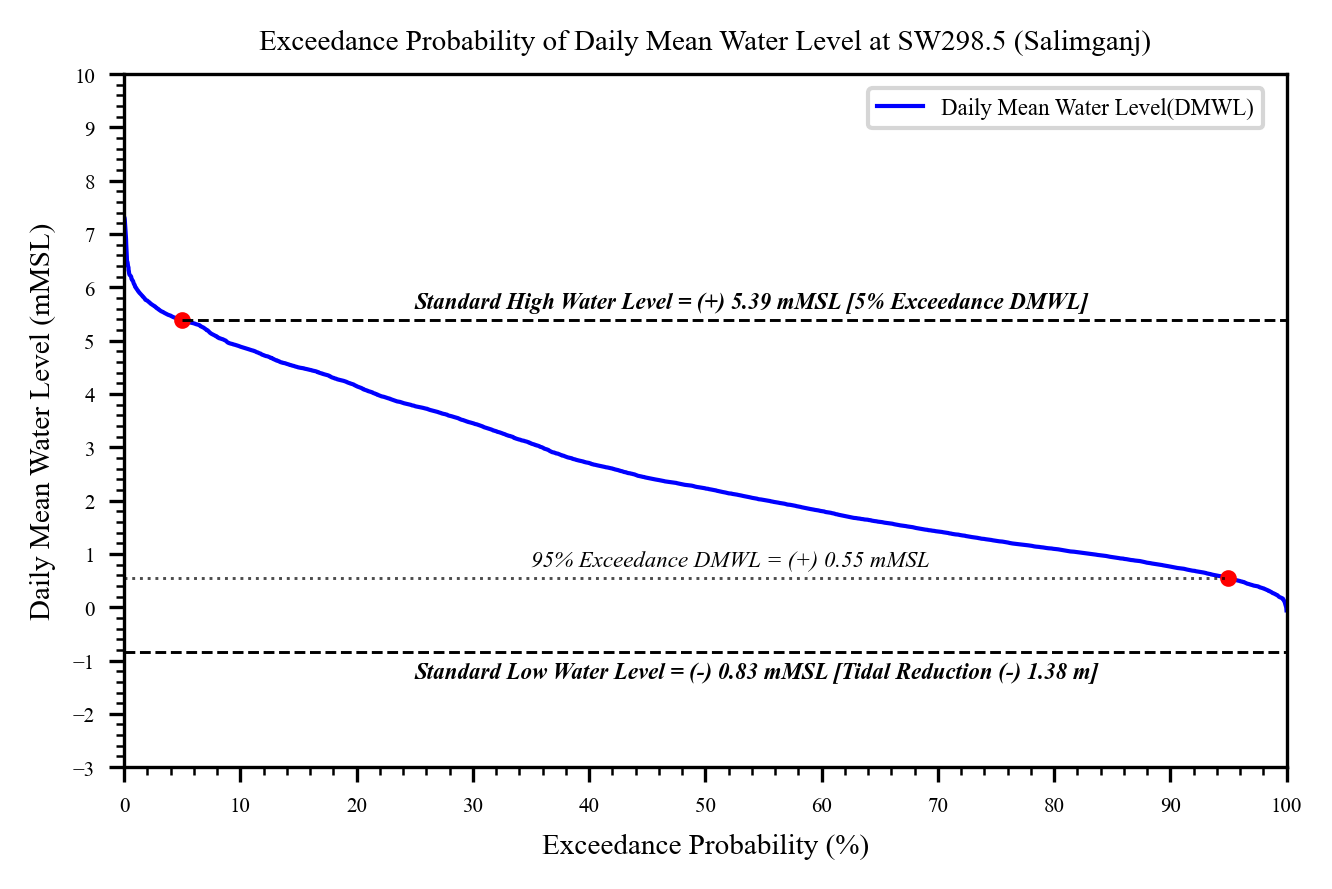

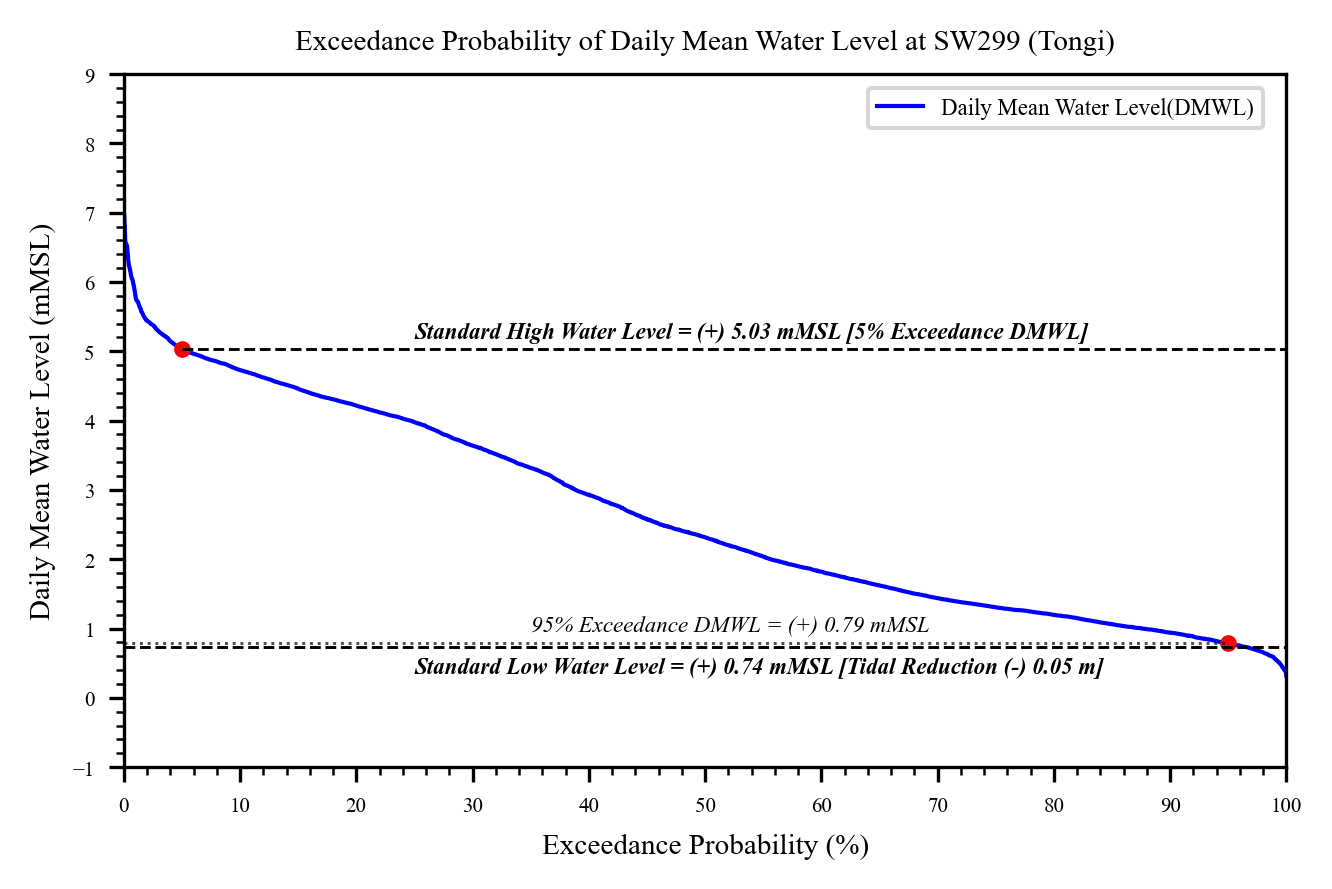

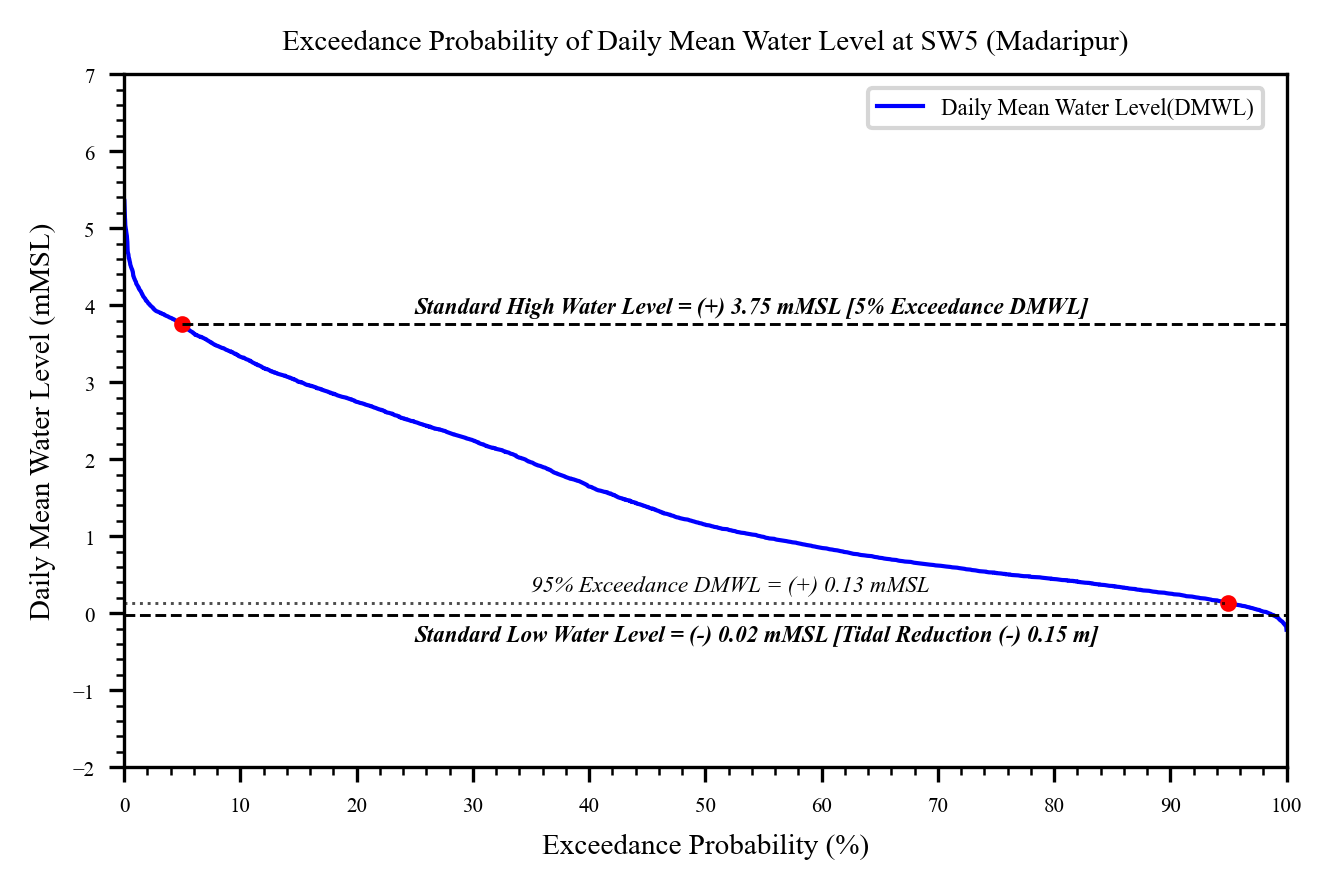

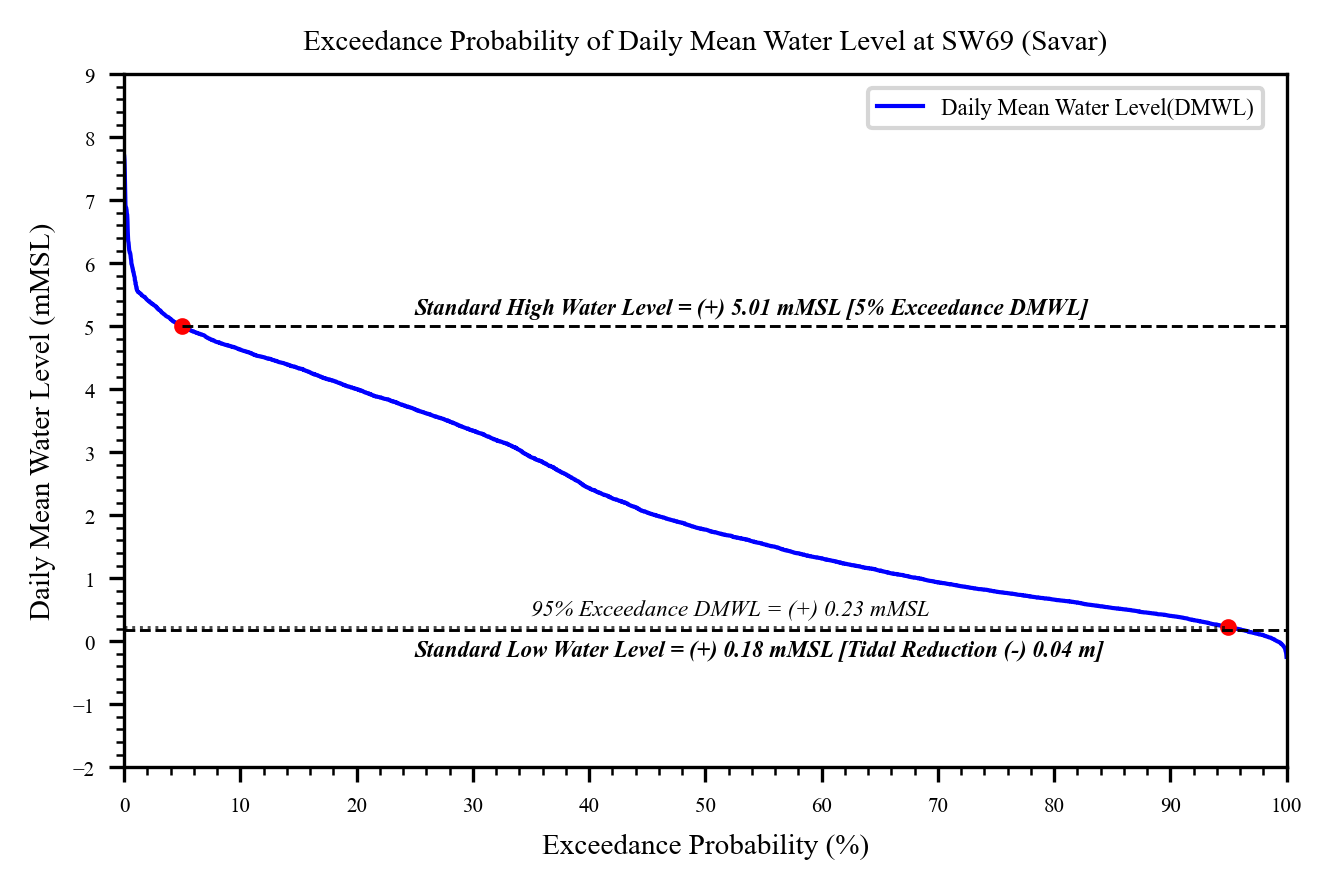

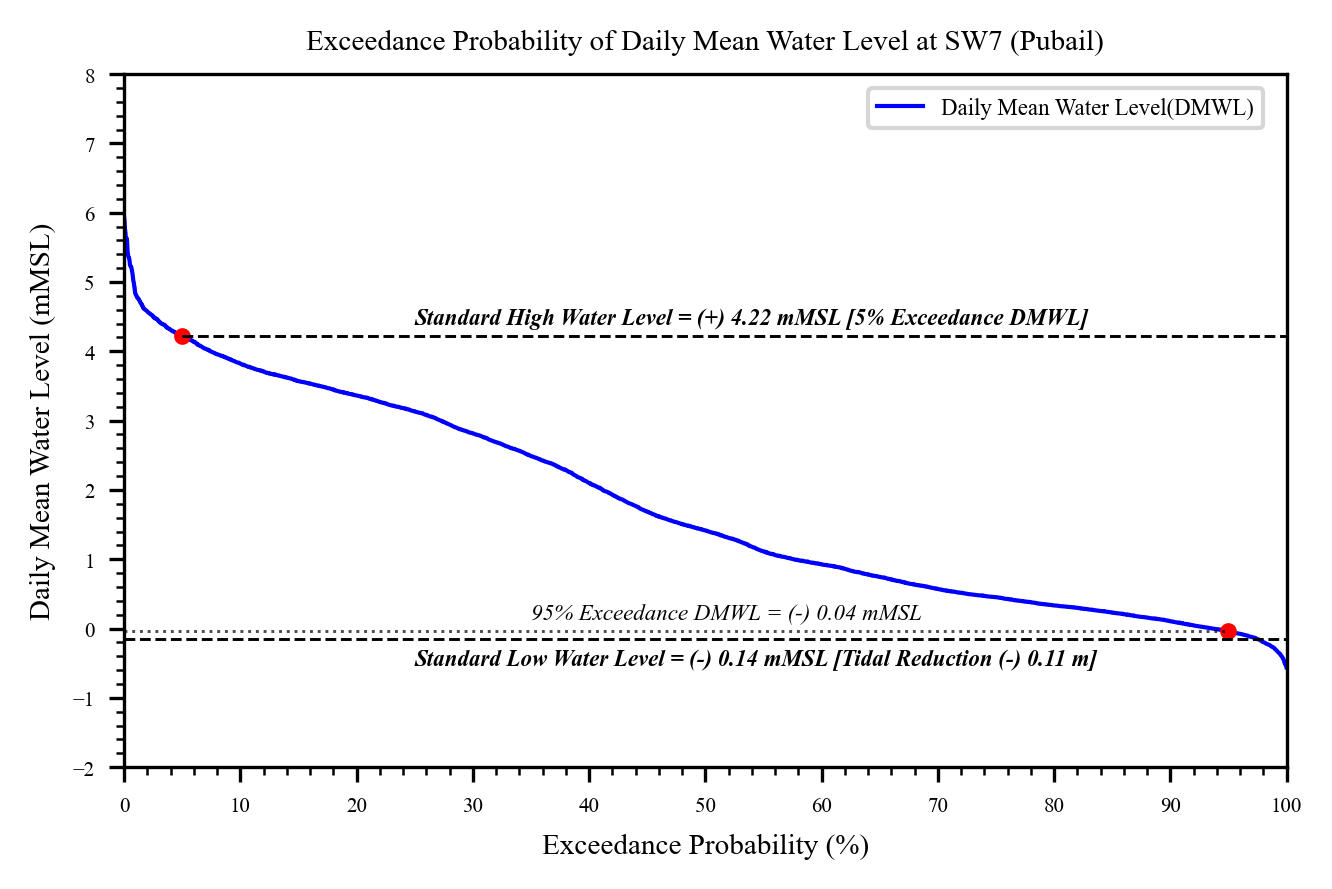

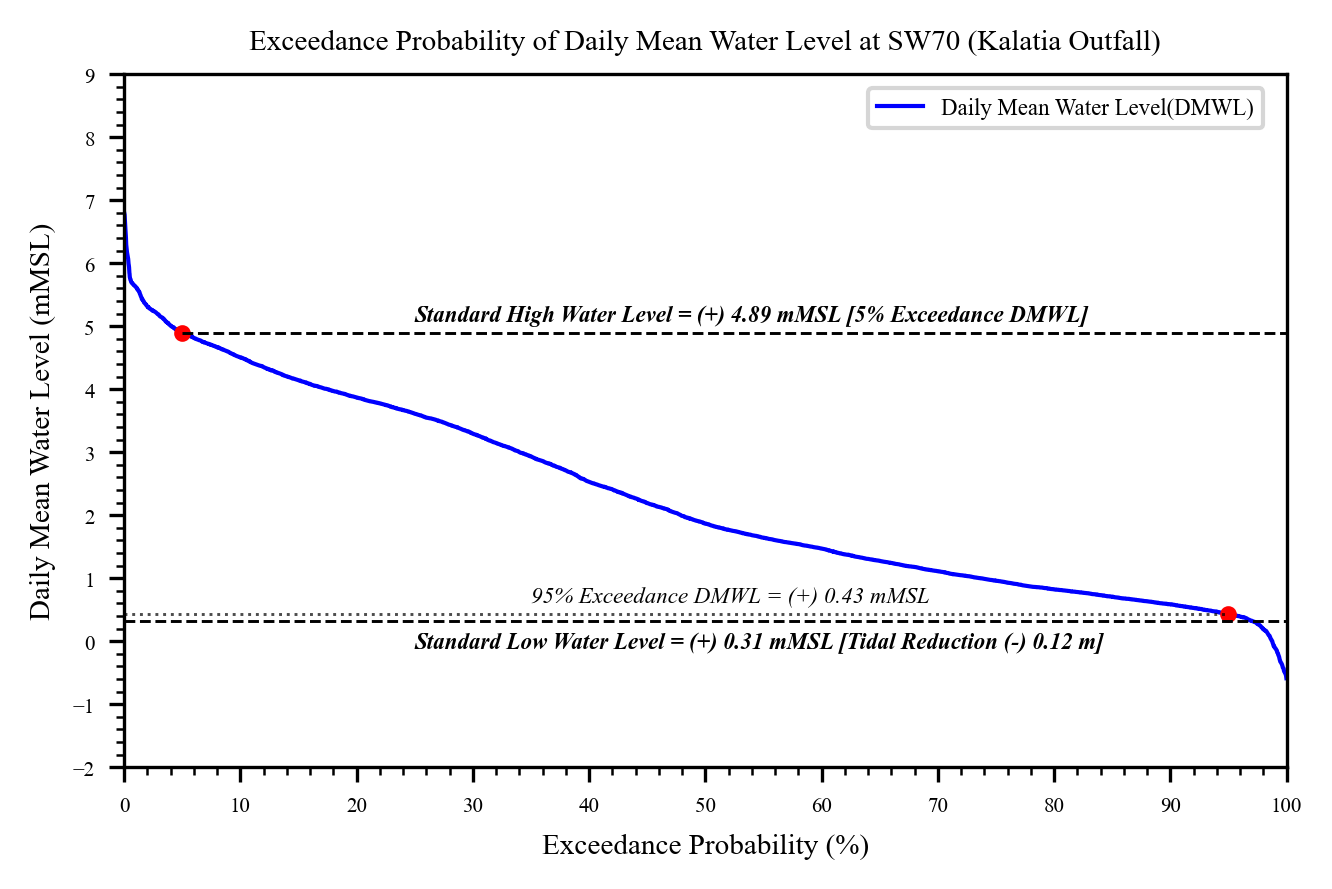

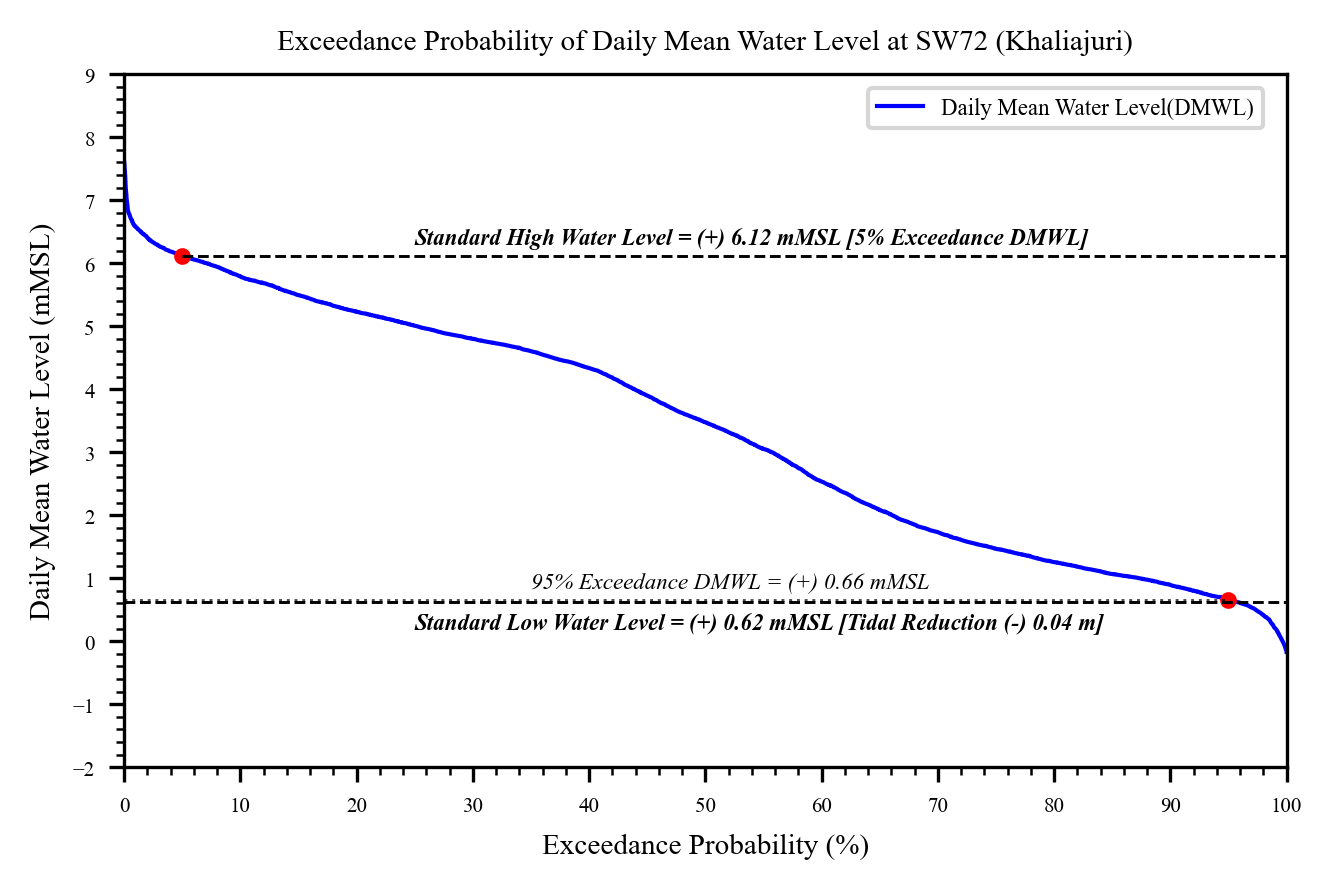

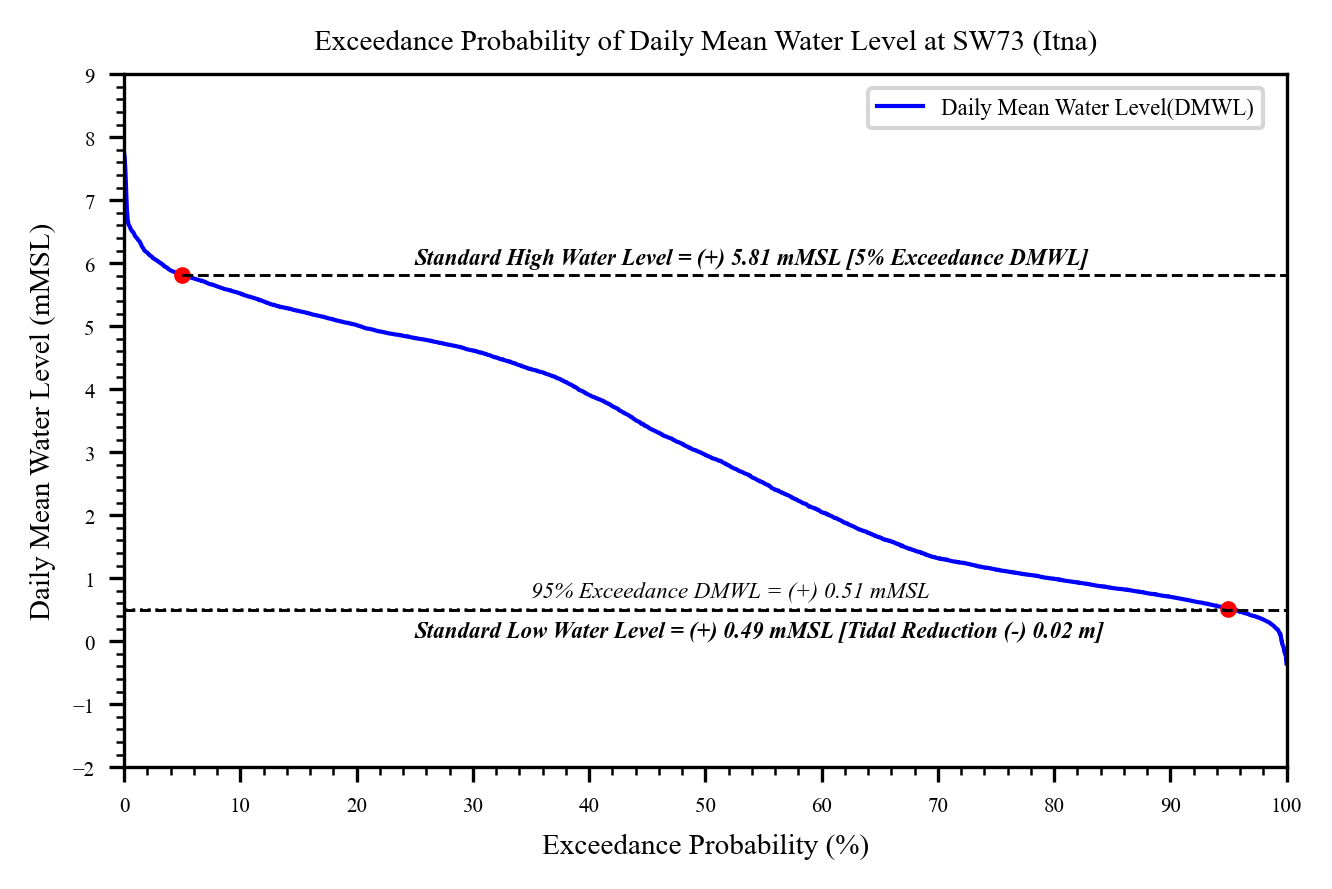

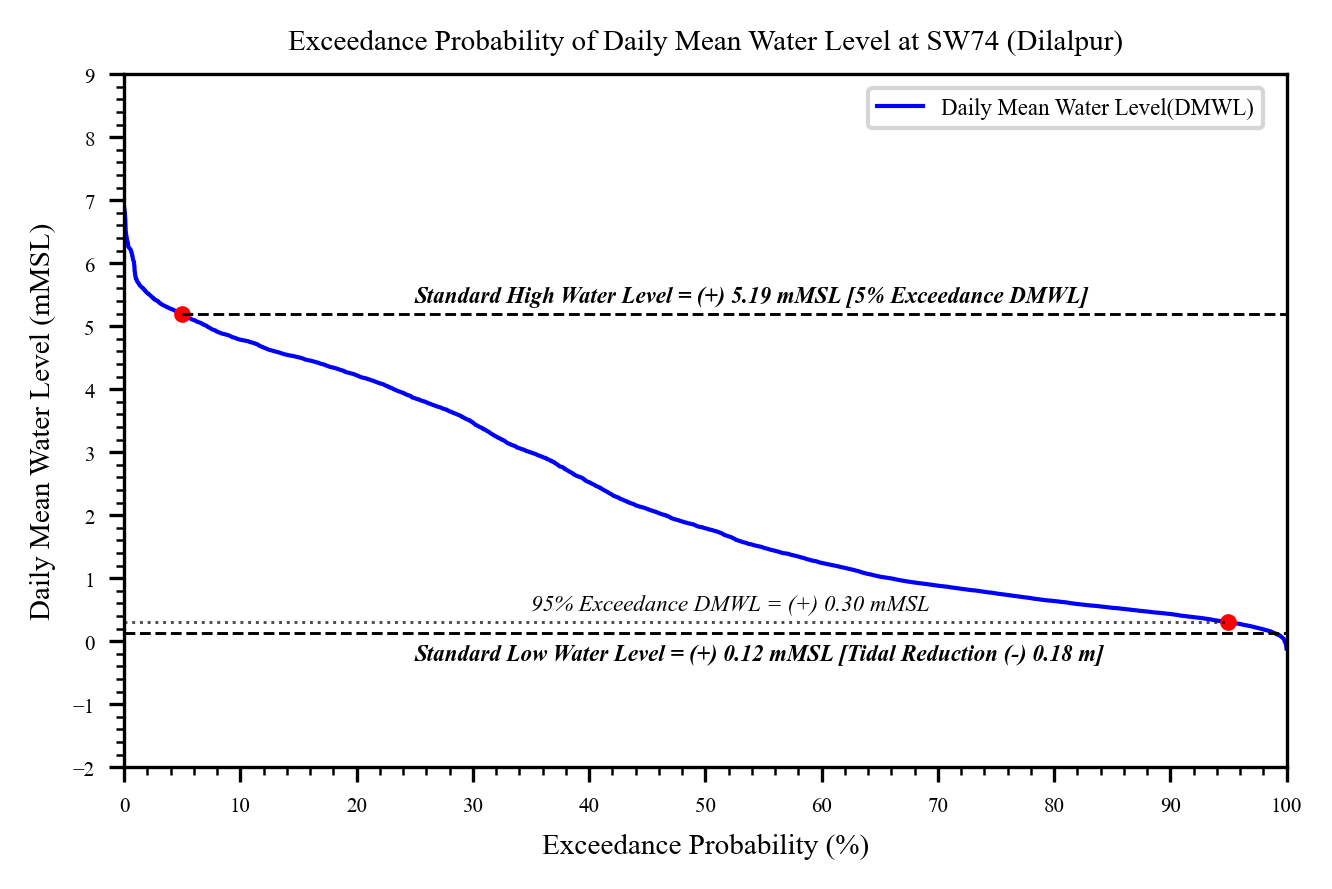

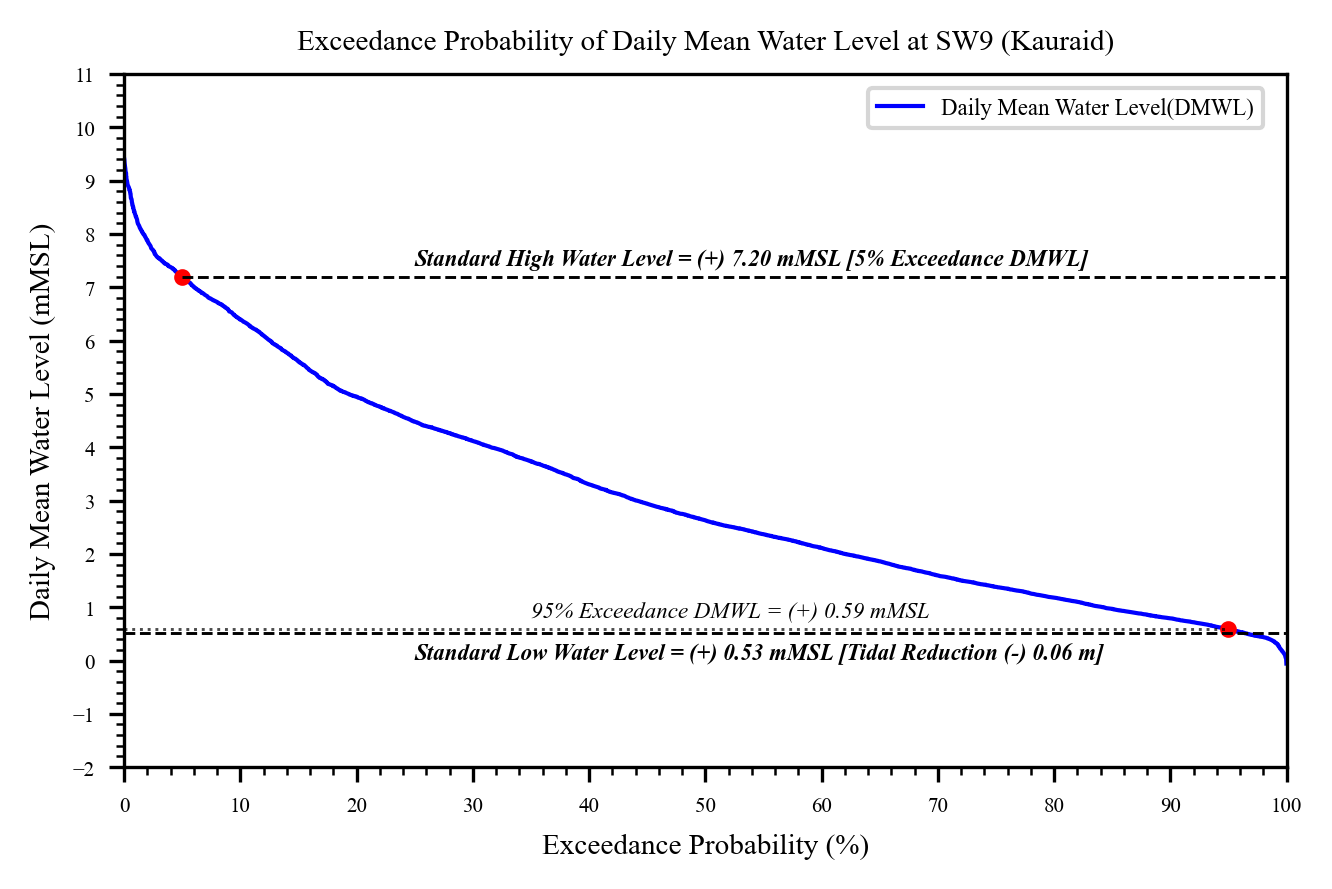

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import glob


# Creating a function to remove the spaces from each item of a string list and returning as a space free item list
def string_space_removal(cons_list):
    cons_name_list = []

    for i in range(0, len(cons_list), 1):
        #         cons_name = cons_list[i].strip() #[Remove space at the beginning and at the end of the string]
        cons_name = cons_list[i].replace(" ", "")

        cons_name_list.append(cons_name)

    return cons_name_list


# Defining a function to calculate the tidal addition for SHWL
def TA_TR_calculation(con_file_path):
    cons_file = con_file_path

    # Reading the constituent file as a table using pandas and creating a dataframe
    txt_df = pd.read_table(cons_file)

    # Creating a new dataframe by taking all rows except the first row using index
    r_txt_df = txt_df[1:]

    # Extracting only first four items using index no. from each row, removing all spaces and casting it as integer
    # to get the "serial no." list of consisting each constituent
    serial_no = r_txt_df[' Constituents from analysis:'].str[:5].replace(" ", "").astype(int)

    # Extracting item 6 to 9 from first(four item) using index no. from each row,
    # removing all spaces using the created function and casting it as float
    # to get the "Constituent Name" list of consisting each constituent
    cons_list = list(r_txt_df[' Constituents from analysis:'].str[6:10])
    constituent_name = string_space_removal(cons_list)

    # Extracting item 14 to 7 from last(six item) using index no. from each row, removing all spaces and casting it as float
    # to get the "Amplitude" list of consisting each constituent
    amplitude = r_txt_df[' Constituents from analysis:'].str[-14:-8].replace(" ", "").astype(float)

    # Extracting last six items using index no. from each row, removing all spaces and casting it as float
    # to get the "Phase" list of consisting each constituent
    phase = r_txt_df[' Constituents from analysis:'].str[-6:].replace(" ", "").astype(float)

    # Creating a dataframe using "Serial no","Constituent Name","Amplitude" & "Phase" list and resetting the name
    cons_df = pd.DataFrame({'serial_no': serial_no, 'constituent_name': constituent_name,
                            'amplitude': amplitude, 'phase': phase})
    cons_df.reset_index(drop=True, inplace=True)

    # Extracting required constituent values(Amplitude of Constituent M2, S2 and MSF) to determine Tidal Addition(TA) for SHWL
    Amp_M2 = cons_df[cons_df['constituent_name'] == 'M2']['amplitude'].values[0]
    Amp_S2 = cons_df[cons_df['constituent_name'] == 'S2']['amplitude'].values[0]
    Amp_MSF = cons_df[cons_df['constituent_name'] == 'MSF']['amplitude'].values[0]

    # Tidal Addition(TA) for SHWL from Tidal Constituents [Using Equation, SHWL = 1.1*(M2 + S2) + MSF]
    tidal_addition = (1.1 * (Amp_M2 + Amp_S2)) + Amp_MSF

    # Spring Tidal Reduction(STR) for SLWL from Tidal Constituents [Using Equation, SHWL = -(1.1*(M2 + S2) + MSF)]
    spring_tidal_reduction = - ((1.1 * (Amp_M2 + Amp_S2)) - Amp_MSF)

    # Neap Tidal Reduction(NTR) for SLWL from Tidal Constituents [Using Equation, SHWL = -(1.1*(M2 + S2) + MSF)]
    neap_tidal_reduction = - ((1.1 * (Amp_M2 - Amp_S2)) + Amp_MSF)

    return Amp_M2, Amp_S2, Amp_MSF, tidal_addition, spring_tidal_reduction, neap_tidal_reduction


# Defining a function to make an annotation text combining SHWL & Tidal Addition or SLWL and Tidal Reduction for the plot
def lwl_annotation(SLWL, tidal_reduction):
    # SLWL (-) negative and tidal reduction (-) negative
    if SLWL < 0 and tidal_reduction < 0:
        anot_label_4 = 'Standard Low Water Level = (-) {b} mMSL [Tidal Reduction (-) {c} m]'.format(
            b="%.2f" % abs(SLWL),
            c="%.2f" % abs(tidal_reduction))
        return anot_label_4

    # SLWL (-) negative and tidal reduction (-) zero
    elif SLWL < 0 and tidal_reduction == 0:
        anot_label_4 = 'Standard Low Water Level = (-) {b} mMSL [Tidal Reduction {c} m]'.format(b="%.2f" % abs(SLWL),
                                                                                                c="%.2f" % abs(
                                                                                                    tidal_reduction))
        return anot_label_4

    # SLWL (0) zero and tidal reduction (-) negative
    elif SLWL == 0 and tidal_reduction < 0:
        anot_label_4 = 'Standard Low Water Level = {b} mMSL [Tidal Reduction (-) {c} m]'.format(b="%.2f" % SLWL,
                                                                                                c="%.2f" % abs(
                                                                                                    tidal_reduction))
        return anot_label_4

    # SLWL (+) positive and tidal reduction (-) negative
    elif SLWL > 0 and tidal_reduction < 0:
        anot_label_4 = 'Standard Low Water Level = (+) {b} mMSL [Tidal Reduction (-) {c} m]'.format(b="%.2f" % SLWL,
                                                                                                    c="%.2f" % abs(
                                                                                                        tidal_reduction))
        return anot_label_4

    # SLWL (+) positive and tidal reduction (0) zero
    elif SLWL > 0 and tidal_reduction == 0:
        anot_label_4 = 'Standard Low Water Level = (+) {b} mMSL [Tidal Reduction {c} m]'.format(b="%.2f" % SLWL,
                                                                                                c="%.2f" % abs(
                                                                                                    tidal_reduction))
        return anot_label_4

    # SLWL (+) positive and tidal reduction (+) positive
    else:
        anot_label_4 = 'Standard Low Water Level = (+) {b} mMSL [Tidal Reduction (+) {c} m]'.format(b="%.2f" % SLWL,
                                                                                                    c="%.2f" % abs(
                                                                                                        tidal_reduction))
        return anot_label_4


# Defining exceedance probability corresponding water level annotation for the plot
def exceedance_probability_annotation(exceedance_proba, exceedance_wl):
    
    if exceedance_proba == 5:
        # For (-) negative water level
        if exceedance_wl < 0:
            anot_label = '(-) {b} mMSL [{a}% Exceedance DMWL]'.format(a=exceedance_proba, b="%.2f" % abs(exceedance_wl))

        # For water level equal to zero (0)
        elif exceedance_wl == 0:
            anot_label = '{b} mMSL [{a}% Exceedance DMWL]'.format(a=exceedance_proba, b="%.2f" % exceedance_wl)

        # For (+) positive water level
        else:
            anot_label = '(+) {b} mMSL [{a}% Exceedance DMWL]'.format(a=exceedance_proba, b="%.2f" % exceedance_wl)
    else:
                # For (-) negative water level
        if exceedance_wl < 0:
            anot_label = '{a}% Exceedance DMWL = (-) {b} mMSL'.format(a=exceedance_proba, b="%.2f" % abs(exceedance_wl))

        # For water level equal to zero (0)
        elif exceedance_wl == 0:
            anot_label = '{a}% Exceedance DMWL = {b} mMSL'.format(a=exceedance_proba, b="%.2f" % exceedance_wl)

        # For (+) positive water level
        else:
            anot_label = '{a}% Exceedance DMWL = (+) {b} mMSL'.format(a=exceedance_proba, b="%.2f" % exceedance_wl)

    return anot_label



# Setting the column name against which column the exceedance probability will be calculated (Requires User Input)
exceedance_prob_col_name = 'Data for Analysis (mMSL)'


# Defining a dataframe to store the SHWL and SLWL of each station (1.SWL = SHWL & SLWL, 2.SHWL, 3.SLWL )
station_swl_df = pd.DataFrame()
station_shwl_df = pd.DataFrame()
station_slwl_df = pd.DataFrame()

# Constituents file folder path
cons_folder_path = r'G:\MJI\SHWL_SLWL\Updated Analysis\BWDB _WL_Stations\Tidal and Non-Tidal\Output\Tidal_Constituents'

for file in glob.glob(r"G:\MJI\SHWL_SLWL\Updated Analysis\BWDB _WL_Stations\Tidal and Non-Tidal\Output\Daily_Avg\*.xlsx"):

    # Splitting the file path with seperator to create path list
    path_list = file.split(os.sep)
    station_id = path_list[-1][:-15]

    # Reading Fortnightly Average Wl file
    df = pd.read_excel(file)

    # Calculating Exceedance Probability of each WL (by removing the blank rows, ranking the water level
    df.dropna(subset=[exceedance_prob_col_name], inplace=True)
    df.sort_values(by= exceedance_prob_col_name, ascending=False, inplace=True)

    # Calculating probability using p = r * 100 / (n + 1)
    df['Ranking'] = df[exceedance_prob_col_name].rank(method='min', ascending=False)
    df['Exceedence Probability (%)'] = (df.loc[:, 'Ranking'] * 100) / (len(df[exceedance_prob_col_name]) + 1)

    # Determining 5% Exceedance Probability by interpolating
    probability_axis = df['Exceedence Probability (%)']  # input
    fortnightly_wl_axis = df[exceedance_prob_col_name]  # input

    # 5% and 95% Exceedance Probability
    probability_vals = [5, 95]

    # 5% and 95% Exceedance Probability Fortnightly Mean Water Level
    high_low_fwl = np.interp(probability_vals, probability_axis, fortnightly_wl_axis)

    # File path of tidal constituent file
    con_file_path = os.path.join(cons_folder_path, '{}.con'.format(station_id))

    # Calculating tidal addition and reduction using TA_TR_calculation function
    Amp_M2, Amp_S2, Amp_MSF, tidal_addition, spring_tidal_reduction, neap_tidal_reduction = TA_TR_calculation(con_file_path)

    tidal_reduction = min(spring_tidal_reduction, neap_tidal_reduction)

    # Calculating Standard High Water Level [SWHL] (SHWL = 5% Fortnightly Mean WL)
    SHWL = high_low_fwl[0]

    # Calculating Standard High Water Level [SWHL] (SHWL = 95% Fortnightly Mean WL + Tidal Reduction)
    SLWL = high_low_fwl[1] + tidal_reduction
    
    # Creating a dataframe to store SHWL and SLWL of the station (1.SWL = SHWL & SLWL, 2.SHWL, 3.SLWL )
    SHWL_SLWL_df = pd.DataFrame({'Station ID':station_id, 'Exceedance Probability(%)':probability_vals,
                                 'Exceedance DMWL (mMSL)': high_low_fwl, 'M2 (m)': Amp_M2, 'S2 (m)': Amp_S2,
                                 'MSF (m)': Amp_MSF, 'Tidal Addition (m)': [tidal_addition, np.nan],
                                 'Spring Tidal Reduction (m)':[np.nan,spring_tidal_reduction],
                                 'Neap Tidal Reduction (m)':[np.nan,neap_tidal_reduction], 
                                 'Tidal Reduction (m)':[np.nan, tidal_reduction], 
                                 'SHWL (mMSL)':[SHWL,np.nan], 'SLWL (mMSL)':[np.nan, SLWL]})
    
    SHWL_df = pd.DataFrame({'Station ID':station_id, 'Exceedance Probability(%)':[probability_vals[0]],
                            'SHWL (mMSL)':SHWL})
    
    SLWL_df = pd.DataFrame({'Station ID':station_id, 'Exceedance Probability(%)':[probability_vals[1]],
                             'Exceedance DMWL (mMSL)': [high_low_fwl[1]], 'M2 (m)': Amp_M2, 'S2 (m)': Amp_S2,
                             'MSF (m)': Amp_MSF, 'Spring Tidal Reduction (m)': spring_tidal_reduction,
                             'Neap Tidal Reduction (m)': neap_tidal_reduction, 
                             'Tidal Reduction (m)':tidal_reduction, 'SLWL (mMSL)': SLWL})
    
    # Updating the SHWL and SLWL datafrmae of each station to the station dataframe
    station_swl_df = pd.concat([station_swl_df, SHWL_SLWL_df])
    station_shwl_df = pd.concat([station_shwl_df, SHWL_df])
    station_slwl_df = pd.concat([station_slwl_df, SLWL_df])

    # Plotting Standard High Water Level(SHWL) and Standard Low Water Level (SLWL)

    font = {'family': 'Times New Roman',
            'weight': 'normal',
            'size': 5.5}

    plt.rc('font', **font)
    plt.rc('xtick', labelsize=5)
    plt.rc('ytick', labelsize=5)

    plt.figure(figsize=(5, 3), dpi=300)

    x_axis = df['Exceedence Probability (%)']  # input
    y_axis = df[exceedance_prob_col_name]  # input

    plt.plot(x_axis, y_axis, lw=1, color='blue', label='Daily Mean Water Level(DMWL)')
    plt.minorticks_on()

    ytic_round_value = 1
    y_low = (y_axis.min() + tidal_reduction) - (y_axis.min() + tidal_reduction) % ytic_round_value - 1
    y_high = (y_axis.max() + tidal_addition) + (ytic_round_value - (y_axis.max() + tidal_addition) % ytic_round_value) + 1

    plt.legend(bbox_to_anchor=(0.98, 0.98), loc=1, borderaxespad=0)

    plt.xticks(np.arange(0, 100 + 1, 10))
    plt.yticks(np.arange(y_low, y_high + 1, ytic_round_value))
    
    # Definging the plot title and x-axis and y-axis label
    plot_title = 'Exceedance Probability of Daily Mean Water Level at {}'.format(station_id)  # name needs to be changed
    plt.title(plot_title, fontweight='roman', fontsize=7)
    plt.xlabel('Exceedance Probability (%)', fontweight='roman', fontsize=7)
    plt.ylabel('Daily Mean Water Level (mMSL)', fontweight='roman', fontsize=7)

    plt.xlim([0, 100])
    plt.ylim([y_low, y_high])

    plt.plot(probability_vals, high_low_fwl, 'o', color='r', markersize=3)
    
    plt.legend(bbox_to_anchor=(0.98, 0.98), loc=1, borderaxespad=0)

    # draw dash lines for 5% exceedance level
    plt.plot([5, 100], [high_low_fwl[0], high_low_fwl[0]], linestyle='--', color='k', lw=0.7, alpha=1)
    anot_label_1 = exceedance_probability_annotation(probability_vals[0], high_low_fwl[0])
    shwl_annotate = 'Standard High Water Level = ' + anot_label_1
    plt.annotate(shwl_annotate, (25, high_low_fwl[0] + 0.15*((y_high-y_low)/(7-(-2)))), color='k', weight='bold', style='italic')

    # draw dash lines for 95% exceedance level
    plt.plot([0, 95], [high_low_fwl[1], high_low_fwl[1]], linestyle='dotted', color='k', lw=0.7, alpha=0.7)
    anot_label_2 = exceedance_probability_annotation(probability_vals[1], high_low_fwl[1])
    plt.annotate(anot_label_2, (35, high_low_fwl[1] + 0.15*((y_high-y_low)/(7-(-2)))), color='k', weight='normal', style='italic')


#     # Standard High Water Level Plotting
#     plt.plot([0, 100], [SHWL, SHWL], '--', color='k', lw=0.7, alpha=1)
#     anot_label_3 = 'Standard High Water Level = (+) {b} mMSL [Tidal Addition (+) {c} m]'.format(b="%.2f" % SHWL,
#                                                                                                 c="%.2f" % tidal_addition)
#     plt.annotate(anot_label_3, (25, SHWL + 0.15*((y_high-y_low)/(7-(-2)))), color='k', weight='bold', style='italic')

    # Standard Low Water Level Plotting
    plt.plot([0, 100], [SLWL, SLWL], '--', color='k', lw=0.7, alpha=1)
    anot_label_4 = lwl_annotation(SLWL, tidal_reduction)
    plt.annotate(anot_label_4, (25, SLWL - 0.35*((y_high-y_low)/(7-(-2)))), color='k', weight='bold', style='italic')
    
    # Saving the exceedance probabilty calculation
    ep_df = df[['Date',exceedance_prob_col_name,'Ranking','Exceedence Probability (%)']]
    ep_df.to_excel(r'G:\MJI\SHWL_SLWL\Updated Analysis\BWDB _WL_Stations\Tidal and Non-Tidal\Output\SHWL_SLWL_from_Daily_Avg\EP_Calculation\{}_EP.xlsx'.format(path_list[-1][:-5]),
                     float_format="%.4f", index= False)
    
    # Saving the figure
    plt.savefig(r'G:\MJI\SHWL_SLWL\Updated Analysis\BWDB _WL_Stations\Tidal and Non-Tidal\Output\SHWL_SLWL_from_Daily_Avg\Plot\{}.jpg'.format(path_list[-1][:-5]), 
                 bbox_inches='tight', dpi=300)
    
    print(path_list[-1][:-5])
    

# Saving all stations SHWL file
station_shwl_df.to_excel(r'G:\MJI\SHWL_SLWL\Updated Analysis\BWDB _WL_Stations\Tidal and Non-Tidal\Output\SHWL_SLWL_from_Daily_Avg\BWBD_SHWL_from_Daily_Avg.xlsx',
                     float_format="%.4f", index= False)

# Saving all stations SLWL file
station_slwl_df.to_excel(r'G:\MJI\SHWL_SLWL\Updated Analysis\BWDB _WL_Stations\Tidal and Non-Tidal\Output\SHWL_SLWL_from_Daily_Avg\BWBD_SLWL_from_Daily_Avg.xlsx',
                     float_format="%.4f", index= False)